# Analyzing Financial Time Series using BigQuery - Redux

With the introduction of [Cloud Datalab](https://cloud.google.com/datalab/) it's worth revisiting an earlier solution we released - [Analyzing Financial Time Series using BigQuery](https://cloud.google.com/solutions/time-series/bigquery-financial-forex) - to show how you can combine BigQuery and Cloud Datalab to increase the power and agility with which you can analyze all your data.

We'll follow the general structure of the original solution, first replicating the original query in BigQuery and using Cloud Datalab to visualize the results, then showing alternatives where necessary that leverage Python code in addition to BigQuery SQL.

First the necessary imports to start the ball rolling...

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gcp.bigquery as bq

## Query for January quotes

In [2]:
%%sql --module time_series

DEFINE QUERY january_quotes
SELECT
 venue,
 currencies,
 time,
 bid,
 ask
FROM
 [speedy-insight-763:timeseries.gbpusd_0114]
ORDER BY
 time ASC
LIMIT 1000;

In [3]:
january_quotes=bq.Query(time_series.january_quotes).to_dataframe()
january_quotes[:5]

,venue,currencies,time,bid,ask
0,XYZ,GBP/USD,2014-01-01 00:00:00.000,1.4995,1.5005
1,XYZ,GBP/USD,2014-01-01 00:00:05.763,1.4988,1.4998
2,XYZ,GBP/USD,2014-01-01 00:00:09.764,1.4979,1.4989
3,XYZ,GBP/USD,2014-01-01 00:00:14.861,1.4993,1.5003
4,XYZ,GBP/USD,2014-01-01 00:00:19.063,1.4989,1.4999


You'll notice we didn't need to make any changes to the time above, Cloud Datalab and Pandas made sense of it for us by default.

Now with a few keystrokes we can visualize the data...

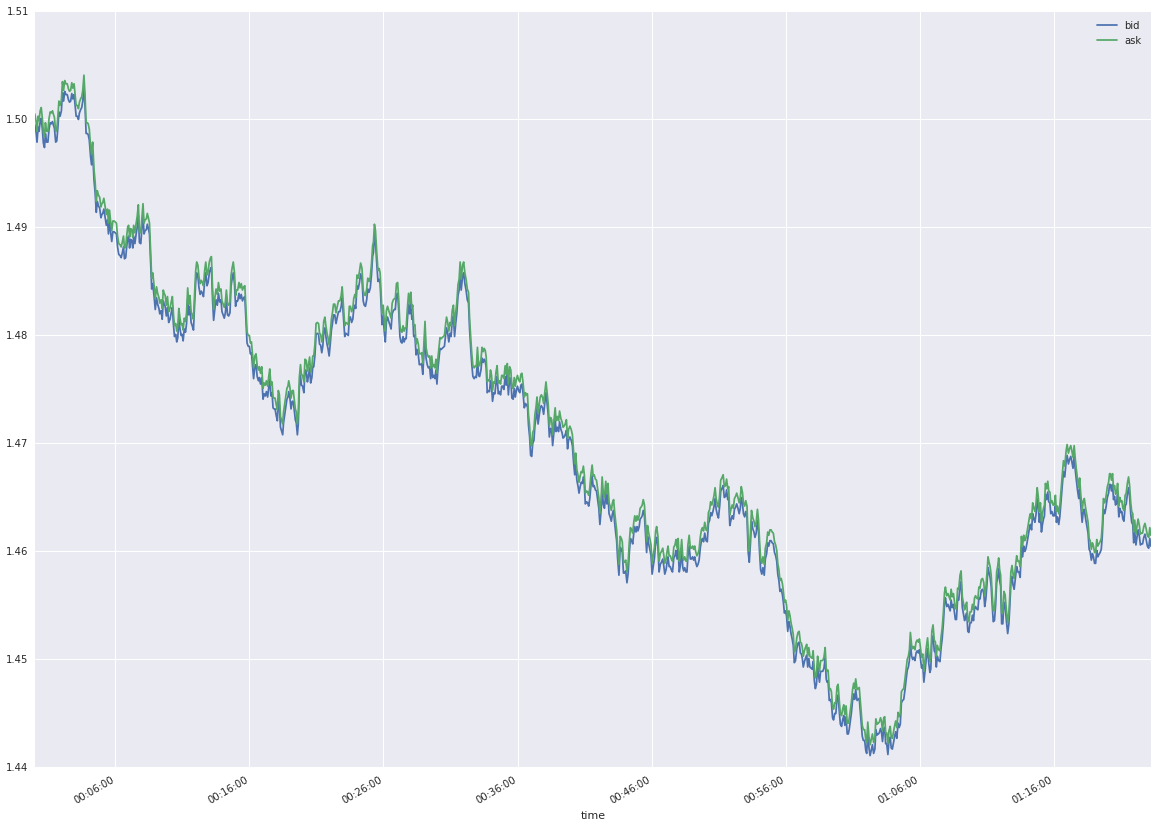

In [4]:
_ = january_quotes.set_index('time').plot(figsize=(20, 15))

## View the bids within a time frame

In [5]:
%%sql --module time_series 

DEFINE QUERY bids_within_a_timeframe
SELECT
  time,
  bid
FROM
  [speedy-insight-763:timeseries.gbpusd_0114]
WHERE
  time BETWEEN TIMESTAMP("2014-01-01 00:00:00.000")
  AND TIMESTAMP("2014-01-01 00:29:59.999")
ORDER BY
  time ASC;

In [6]:
bids_within_a_timeframe=bq.Query(time_series.bids_within_a_timeframe).to_dataframe()
bids_within_a_timeframe[:5]

,time,bid
0,2014-01-01 00:00:00.000,1.4995
1,2014-01-01 00:00:05.763,1.4988
2,2014-01-01 00:00:09.764,1.4979
3,2014-01-01 00:00:14.861,1.4993
4,2014-01-01 00:00:19.063,1.4989


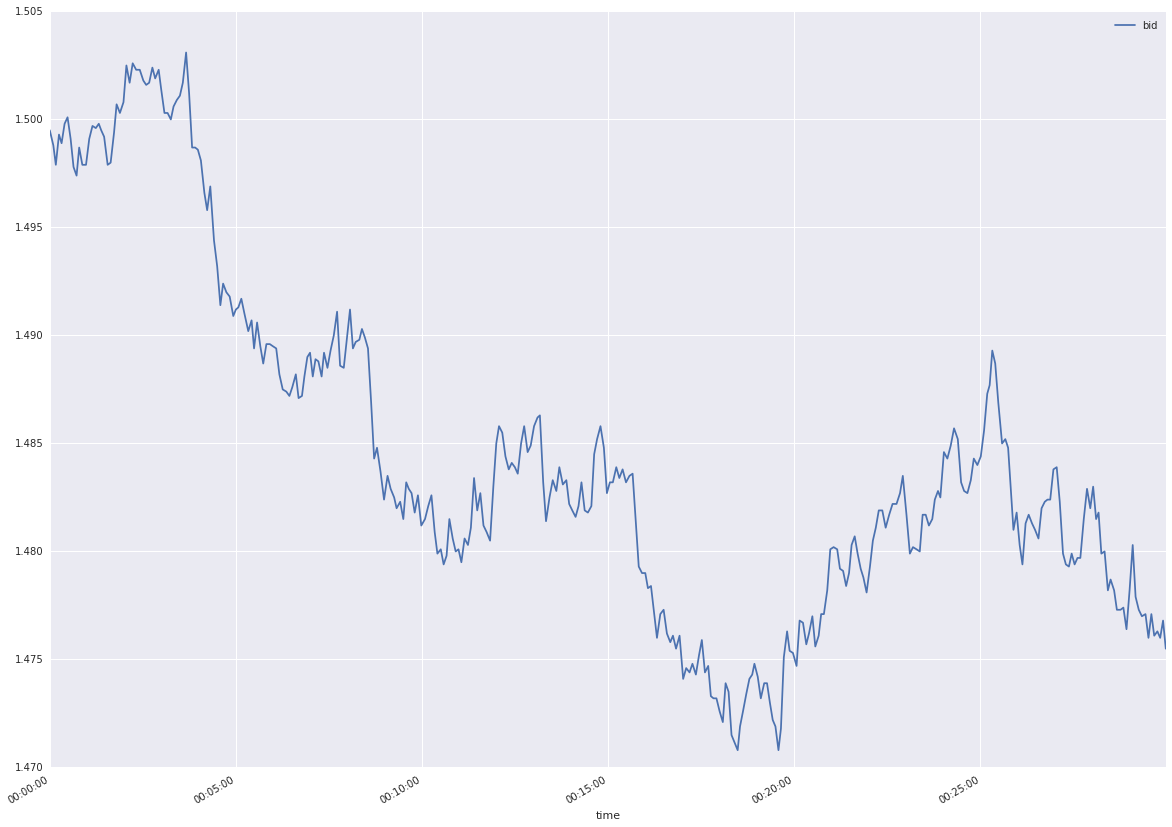

In [7]:
_ = bids_within_a_timeframe.set_index('time').plot(figsize=(20, 15))

## Combine tables

In [8]:
%%sql --module time_series 

DEFINE QUERY combining_tables_1
SELECT
  MIN(time) AS time1,
  MAX(time)AS time2
FROM
  (TABLE_QUERY([speedy-insight-763:timeseries],
      'table_id CONTAINS "gbpusd"'));

DEFINE QUERY combining_tables_2
SELECT
  STRFTIME_UTC_USEC(time,"%m-%d-%Y %r") AS time,
  ask
FROM
  [speedy-insight-763:timeseries.gbpusd_0114],
  [speedy-insight-763:timeseries.gbpusd_0214]
WHERE
  time BETWEEN TIMESTAMP("2014-01-31 23:30:00.000")
  AND TIMESTAMP("2014-02-01 00:29:59.999")
ORDER BY
  time ASC;

In [9]:
combining_tables_1=bq.Query(time_series.combining_tables_1).to_dataframe()
combining_tables_1

,time1,time2
0,2014-01-01,2014-02-28 23:59:57.383


In [10]:
combining_tables_2=bq.Query(time_series.combining_tables_2).to_dataframe()
combining_tables_2[:5]

,time,ask
0,01-31-2014 11:30:02 PM,1.7058
1,01-31-2014 11:30:05 PM,1.7055
2,01-31-2014 11:30:09 PM,1.7059
3,01-31-2014 11:30:11 PM,1.7046
4,01-31-2014 11:30:14 PM,1.7052


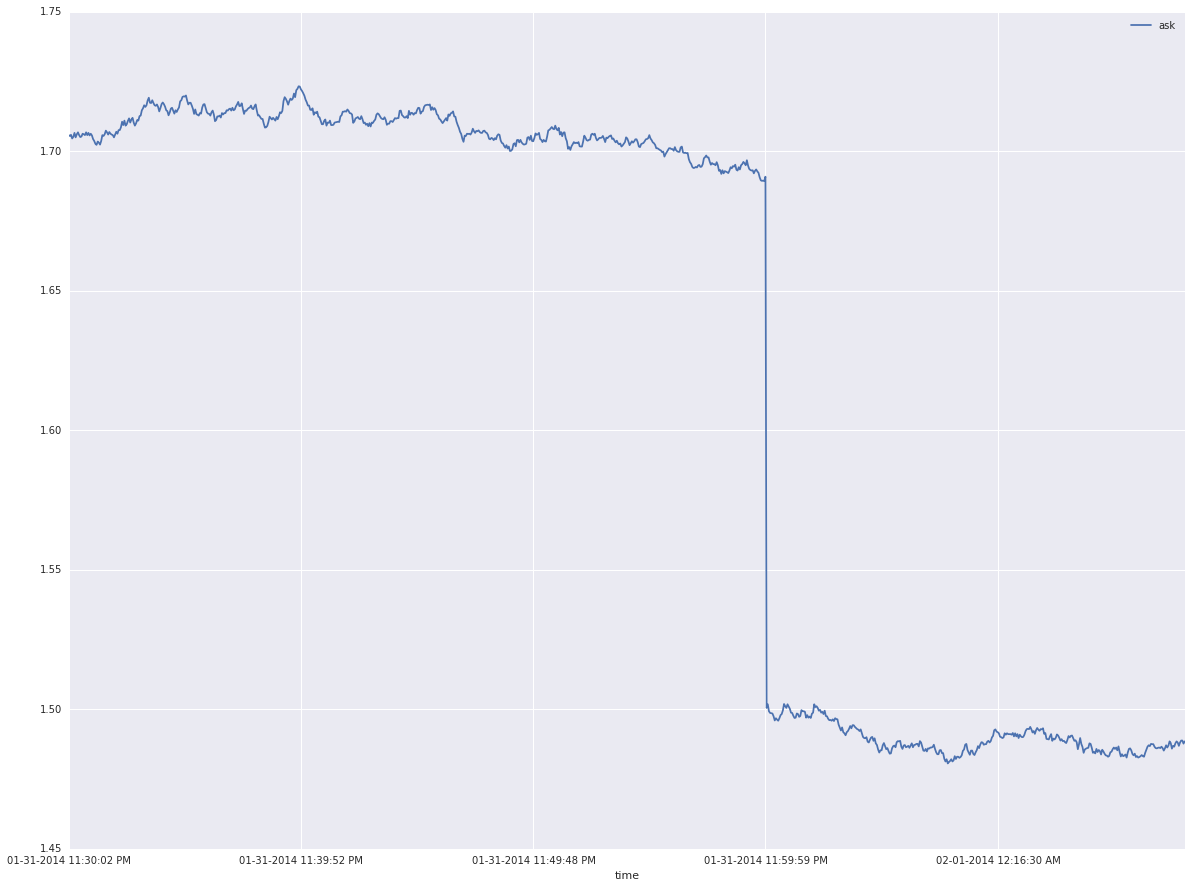

In [11]:
_ = combining_tables_2.set_index('time').plot(figsize=(20, 15))

## Analyze the frequency of data

In [12]:
%%sql --module time_series 

DEFINE QUERY analyze_frequency_1
SELECT
  HOUR(time) AS hour,
  COUNT(time) AS num_ticks
FROM
  [speedy-insight-763:timeseries.gbpusd_0114]
WHERE
  time BETWEEN TIMESTAMP("2014-01-16 00:00:00.000")
  AND TIMESTAMP("2014-01-16 23:59:59.999")
GROUP BY
  hour
ORDER BY
  hour ASC;

DEFINE QUERY analyze_frequency_raw
SELECT
  time
FROM
  [speedy-insight-763:timeseries.gbpusd_0114]
ORDER BY
  time ASC;

DEFINE QUERY analyze_frequency_2
SELECT
  HOUR(time) AS hour,
  COUNT(time)/COUNT(DISTINCT DAY(time)) AS avg_ticks
FROM
  [speedy-insight-763:timeseries.gbpusd_0114]
GROUP BY
  hour
ORDER BY
  hour ASC;

In [13]:
analyze_frequency_1=bq.Query(time_series.analyze_frequency_1).to_dataframe()
analyze_frequency_1

,hour,num_ticks
0,0,719
1,1,722
2,2,723
3,3,717
4,4,1201
5,5,1207
6,6,1204
7,7,1193
8,8,1791
9,9,1804


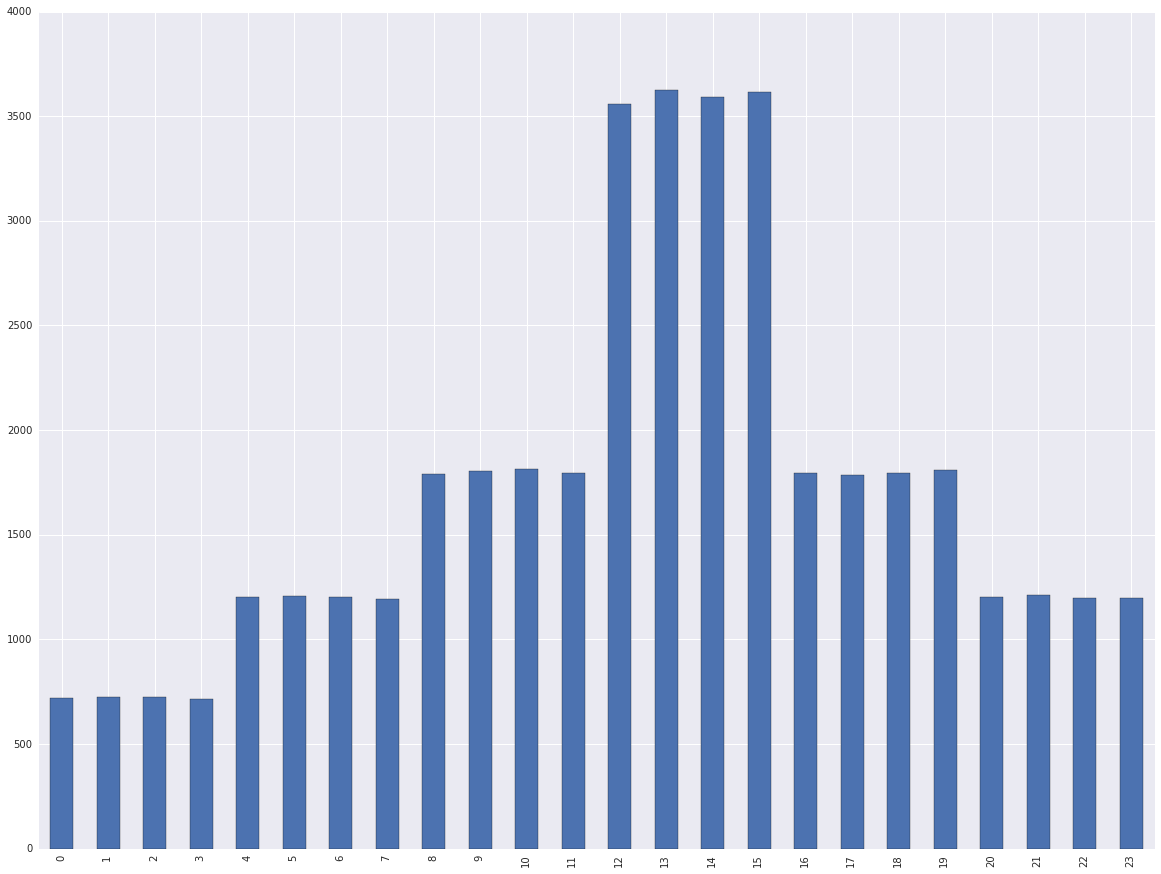

In [14]:
_ = analyze_frequency_1.num_ticks.plot(kind='bar', figsize=(20, 15))

In [15]:
analyze_frequency_raw=bq.Query(time_series.analyze_frequency_raw).to_dataframe()
analyze_frequency_raw[:5]

,time
0,2014-01-01 00:00:00.000
1,2014-01-01 00:00:05.763
2,2014-01-01 00:00:09.764
3,2014-01-01 00:00:14.861
4,2014-01-01 00:00:19.063


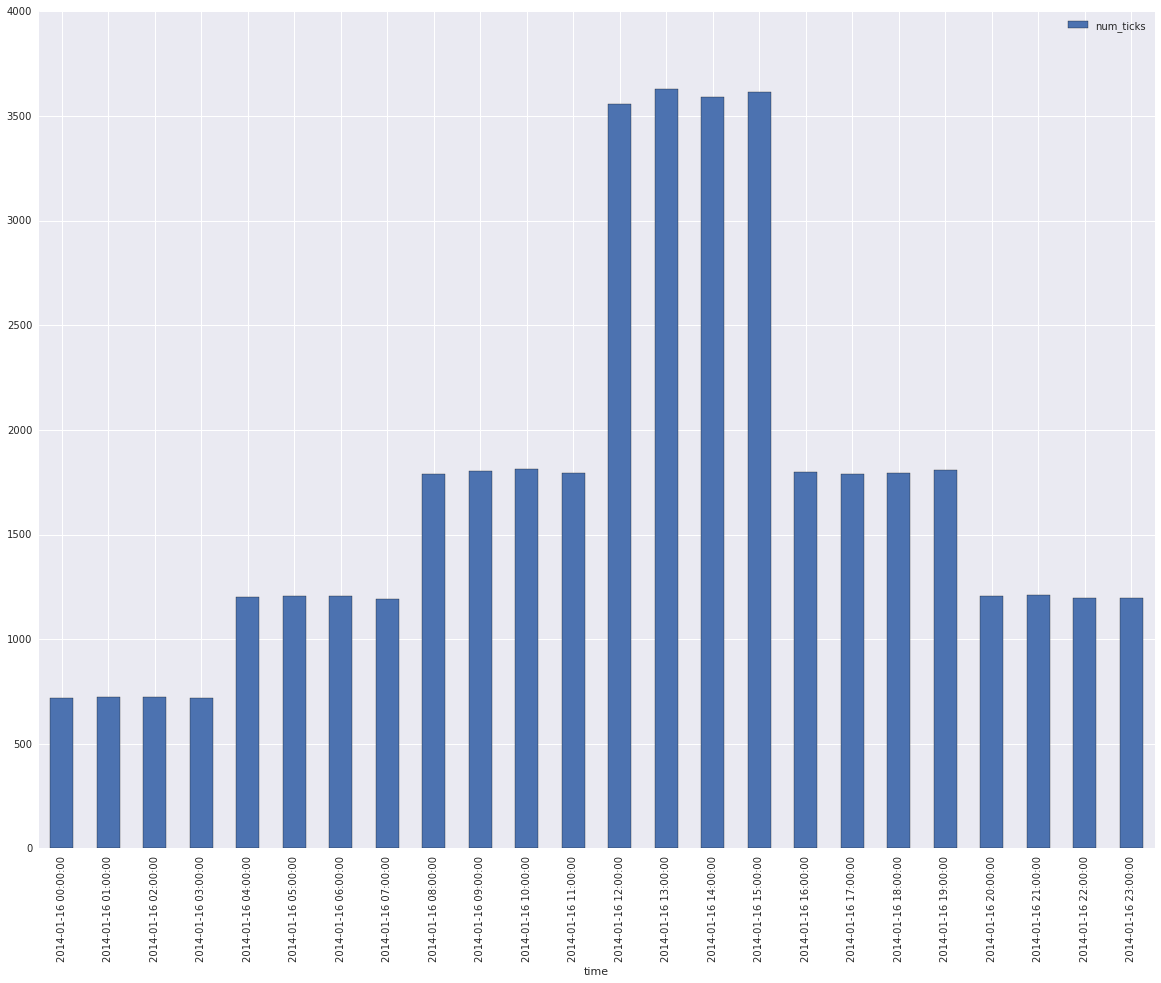

In [16]:
analyze_frequency_1_1_analysis = \
  analyze_frequency_raw[(analyze_frequency_raw['time'] >= '2014-01-16 00:00:00.000') & 
                        (analyze_frequency_raw['time'] < '2014-01-17 00:00:00.000')]
  
analyze_frequency_1_1_analysis = analyze_frequency_1_1_analysis.set_index('time')
analyze_frequency_1_1_analysis['num_ticks'] = 1
analyze_frequency_1_1_analysis = analyze_frequency_1_1_analysis.resample('H', how='sum')
_ = analyze_frequency_1_1_analysis.plot(kind='bar', figsize=(20, 15))

In [17]:
analyze_frequency_2=bq.Query(time_series.analyze_frequency_2).to_dataframe()
analyze_frequency_2

,hour,avg_ticks
0,0,720.548387
1,1,719.129032
2,2,720.483871
3,3,719.903226
4,4,1198.290323
5,5,1200.258065
6,6,1200.774194
7,7,1199.516129
8,8,1796.419355
9,9,1802.064516


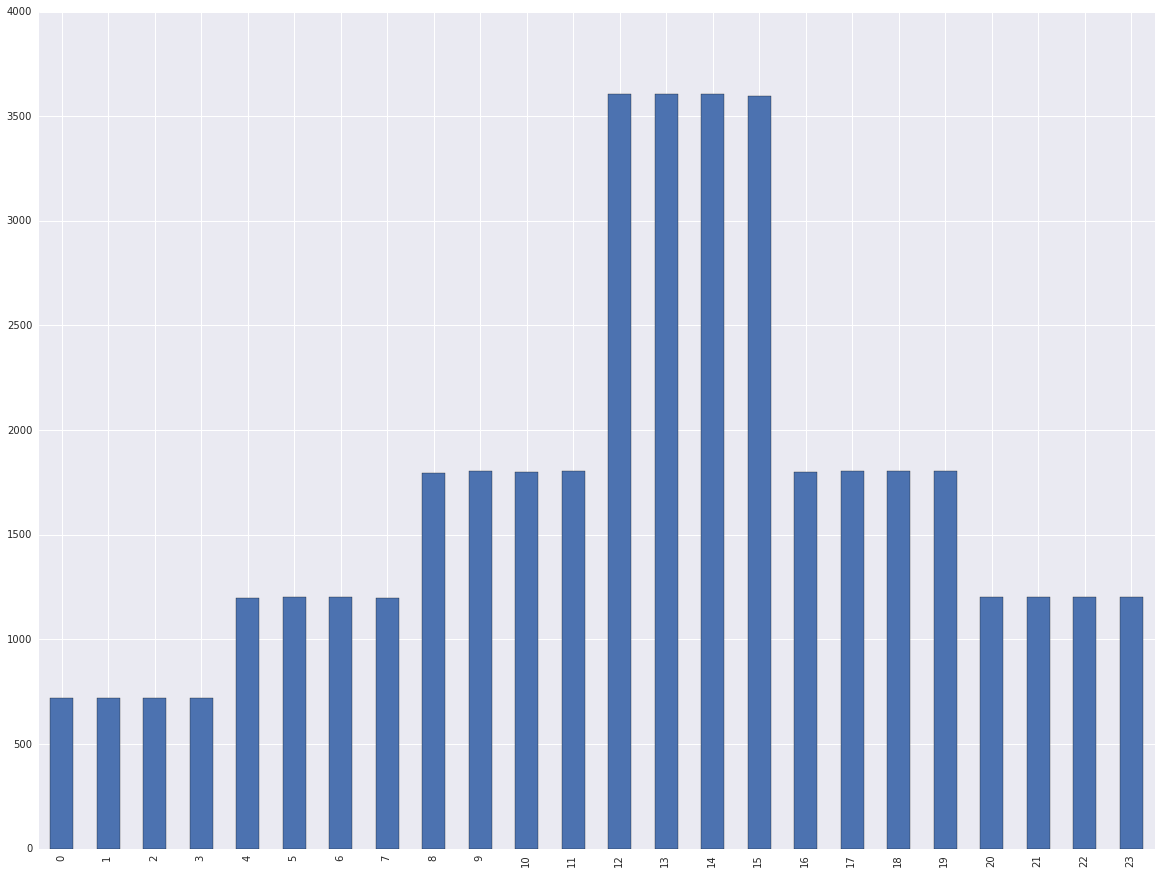

In [18]:
_ = analyze_frequency_2['avg_ticks'].plot(kind='bar', figsize=(20, 15))

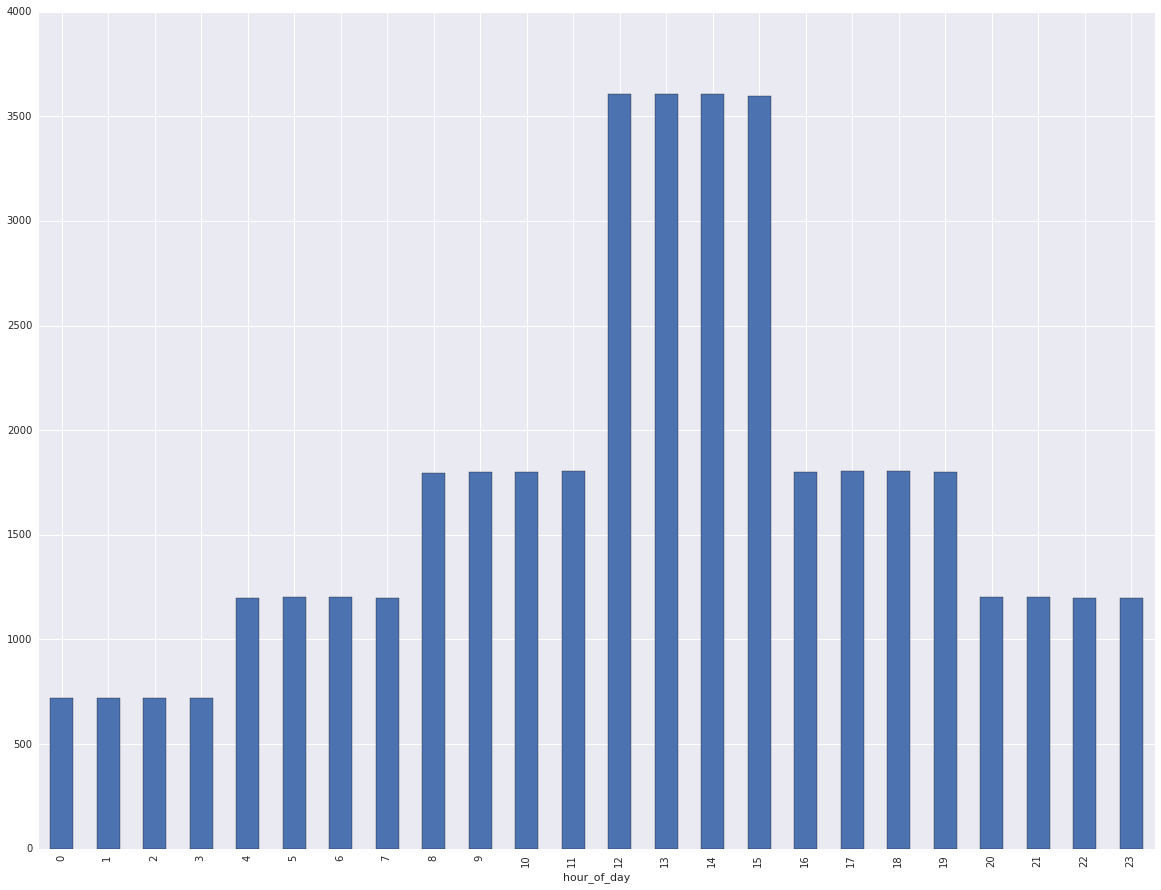

In [19]:
analyze_frequency_2_1_analysis = analyze_frequency_raw.copy()
analyze_frequency_2_1_analysis['num_ticks'] = 1
analyze_frequency_2_1_analysis['hour_of_day'] = \
  analyze_frequency_2_1_analysis['time'].apply(lambda x: x.hour)
by_hour_of_day = analyze_frequency_2_1_analysis.groupby('hour_of_day')
sum_by_hour_of_day = by_hour_of_day.aggregate(np.sum)
sum_by_hour_of_day['average'] = sum_by_hour_of_day['num_ticks']/31
_ = sum_by_hour_of_day['average'].plot(kind='bar', figsize=(20, 15))

## Compute a moving average

In [77]:
%%sql --module time_series

DEFINE QUERY raw_data_for_moving_average
SELECT
  time bid_time,
  bid
FROM
  [speedy-insight-763:timeseries.gbpusd_0114]
WHERE
  time BETWEEN TIMESTAMP("2014-01-16 09:00:00.000")
  AND TIMESTAMP("2014-01-16 11:59:59.999")
ORDER BY
  time ASC;

DEFINE QUERY moving_average_1
select
  timestamp(end_ts_in_sec) bid_time,
  avg(bid) avg_bid
from
  (
  select 
    bid,
    timestamp_to_sec(time) + i end_ts_in_sec
  from [speedy-insight-763:timeseries.gbpusd_0114] a
  cross join
    (
    select i from [fh-bigquery:public_dump.numbers_255] WHERE i < 60
    ) b
  where 
    time
      BETWEEN TIMESTAMP("2014-01-16 09:00:00.000")
      AND TIMESTAMP("2014-01-16 11:59:59.999")
  )
group by bid_time
order by bid_time asc

DEFINE QUERY moving_average_3
SELECT
  S1.time AS bid_time,
  AVG(S2.bid) AS avg_bid
FROM
  [speedy-insight-763:timeseries.gbpusd_0114] AS S1
JOIN EACH
  [speedy-insight-763:timeseries.gbpusd_0114] AS S2
ON
  S1.time = S2.time
WHERE
  TIMESTAMP_TO_SEC(S2.time)
  BETWEEN (TIMESTAMP_TO_SEC(S1.time) - 60)
  AND TIMESTAMP_TO_SEC(S1.time)
  AND
  S1.time
  BETWEEN TIMESTAMP("2014-01-16 09:00:00.000")
  AND TIMESTAMP("2014-01-16 11:59:59.999")
GROUP BY
  bid_time
ORDER BY
  bid_time ASC;

In [44]:
raw_data_for_moving_average=bq.Query(time_series.raw_data_for_moving_average).to_dataframe()

In [21]:
moving_average_1=bq.Query(time_series.moving_average_1).to_dataframe()
moving_average_1[:5]

,bid_time,avg_bid
0,2014-01-16 09:00:02,1.995400
1,2014-01-16 09:00:03,1.995400
2,2014-01-16 09:00:04,1.995250
3,2014-01-16 09:00:05,1.995250
4,2014-01-16 09:00:06,1.995233


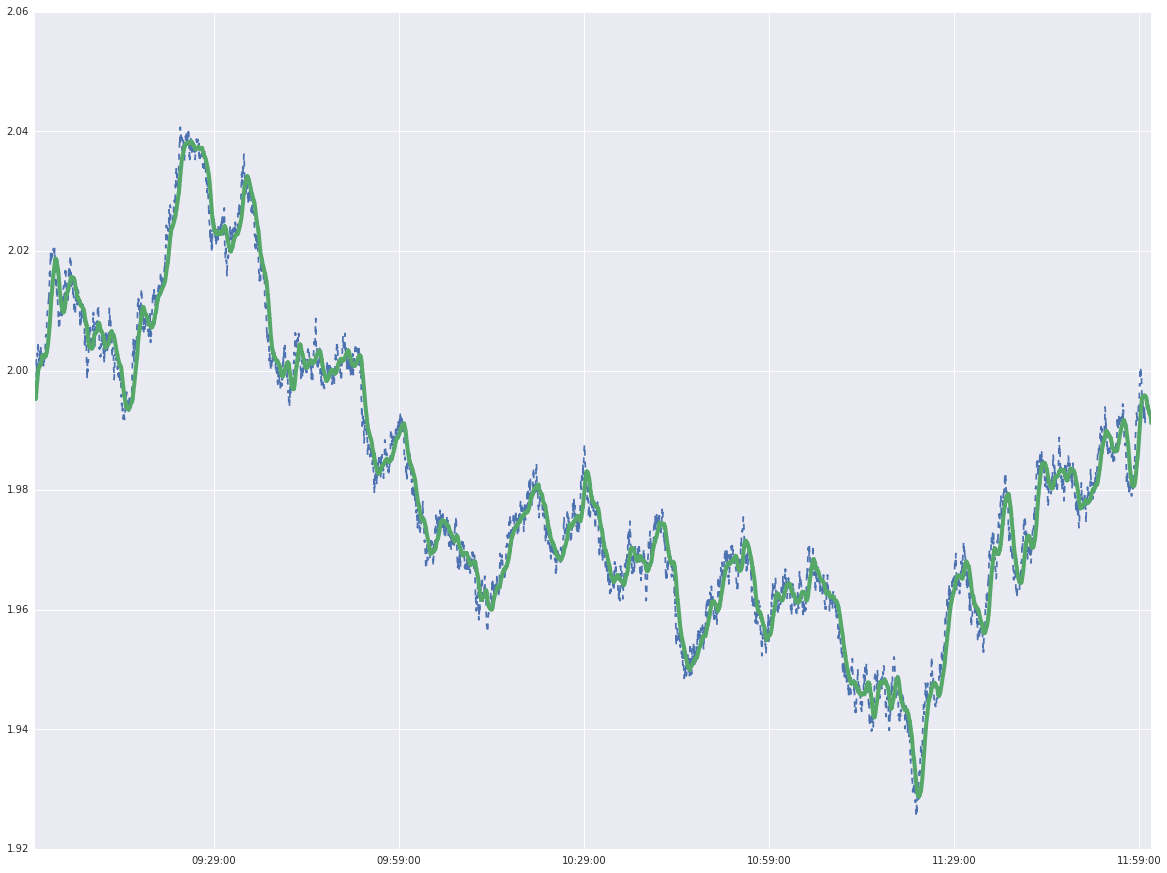

In [67]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

plt.plot(raw_data_for_moving_average.bid_time, raw_data_for_moving_average.bid, '--')
plt.plot(moving_average_1.bid_time, moving_average_1.avg_bid, linewidth=4.0)
plt.show()

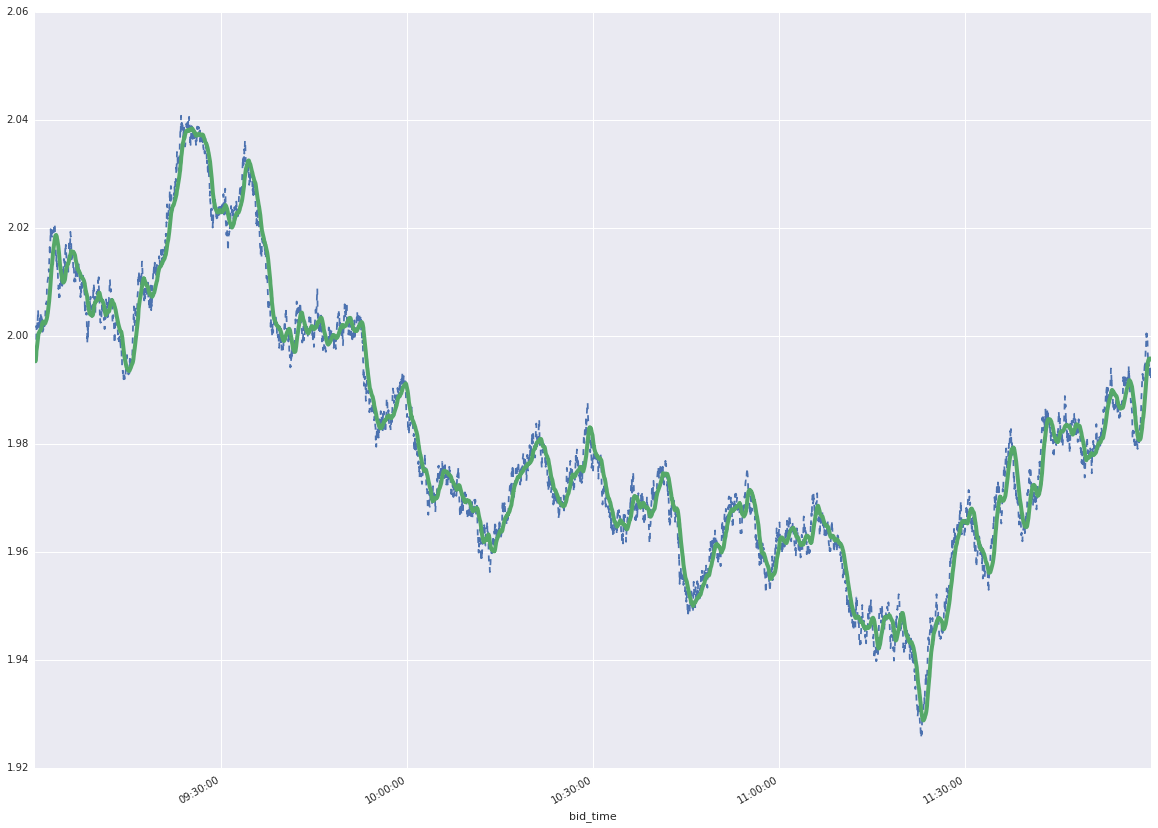

In [68]:
def calculate_moving_average(finish):
    series = raw_data_for_moving_average.bid[
      (raw_data_for_moving_average.bid_time > finish - pd.DateOffset(seconds=60)) & 
      (raw_data_for_moving_average.bid_time <= finish)]
    return np.mean(series)

raw_data_for_moving_average['moving_average'] = raw_data_for_moving_average.bid_time.apply(calculate_moving_average)
raw_data_for_moving_average.set_index('bid_time').bid.plot(style='--', figsize=(20, 15))
_ = raw_data_for_moving_average.set_index('bid_time').moving_average.plot(linewidth=4.0, figsize=(20, 15))

In [78]:
moving_average_3=bq.Query(time_series.moving_average_3).to_dataframe()
moving_average_3[:5]

,bid_time,avg_bid
0,2014-01-16 09:00:02.185,1.9954
1,2014-01-16 09:00:04.423,1.9951
2,2014-01-16 09:00:05.610,1.9952
3,2014-01-16 09:00:08.684,1.9965
4,2014-01-16 09:00:10.067,1.9973


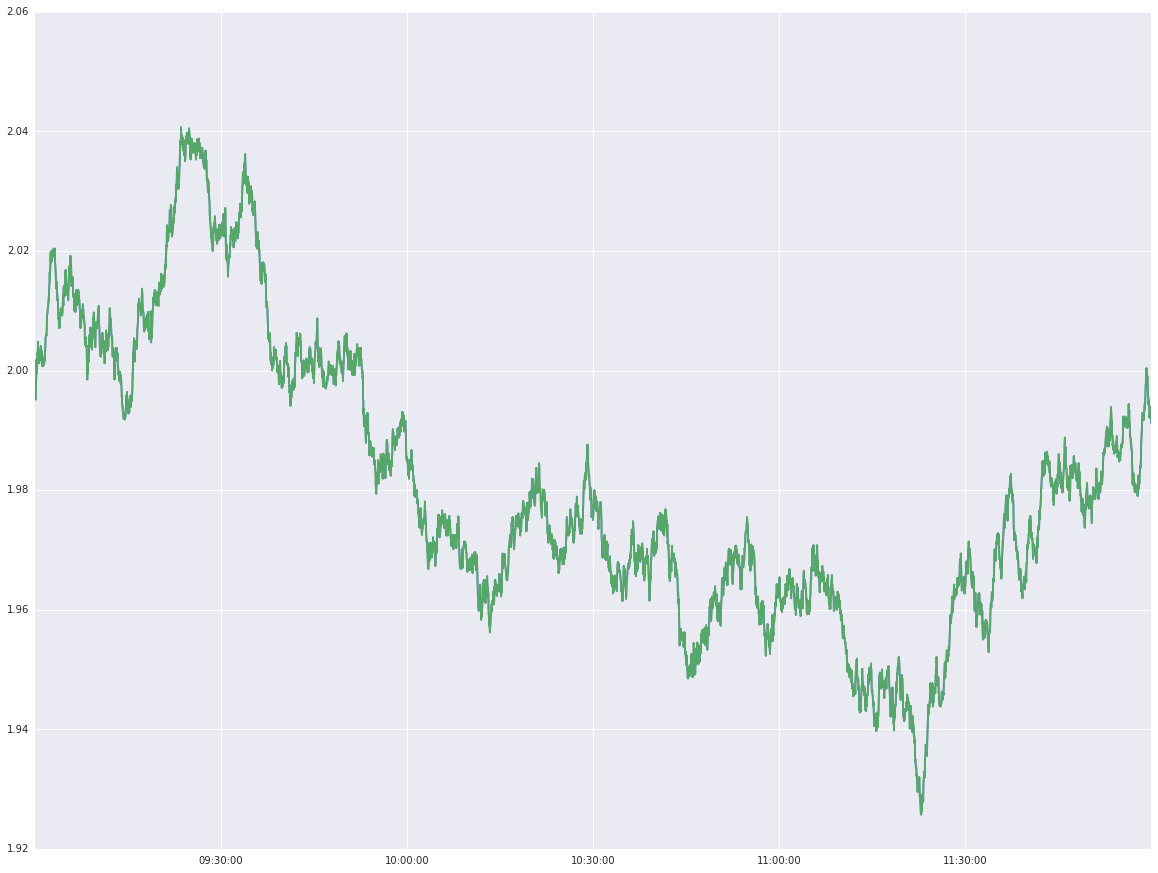

In [83]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

plt.plot(raw_data_for_moving_average.bid_time, raw_data_for_moving_average.bid)
plt.plot(moving_average_3.bid_time, moving_average_3.avg_bid)
plt.show()